In [1]:
import sys
sys.path.append('../src')
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *

In [2]:
MODELS = ['Feedforward', 'EI network\n(HVC$\\to$E)', 'EI network\n(E$\\to$E)']
NE = 600
Ds_pert = np.array([10, 50, 100, 200, 300, 400])
Ks_input = np.array([5, 10, 20, 40, 60, 100])
T_burn = 500

In [3]:
df_vpp = dict(tid=[], model=[], d=[], perturbed=[], unperturbed=[], 
              spar1=[], spar2=[], spar3=[])

for i in range(1, 6):
    with open('../results/vary_percent_pert_%d.pkl' % i, 'rb') as f:
        # EIres, FFres, err, syl = pickle.load(f)
        FF_zs, EI_zs, EIrec_zs, FF_sparsity, EI_sparsity, EIrec_sparsity = pickle.load(f)
        df_vpp['tid'].extend([i] * len(Ds_pert) * len(MODELS))
        aux = [MODELS[0]]*len(Ds_pert)+[MODELS[1]]*len(Ds_pert)+[MODELS[2]]*len(Ds_pert)
        df_vpp['model'].extend(aux)
        df_vpp['d'].extend(list(Ds_pert / NE * 100) * len(MODELS))
        df_vpp['perturbed'].extend(list(map(lambda x: x[0], FF_zs)))
        df_vpp['perturbed'].extend(list(map(lambda x: x[0], EI_zs)))
        df_vpp['perturbed'].extend(list(map(lambda x: x[0], EIrec_zs)))
        df_vpp['unperturbed'].extend(list(map(lambda x: x[1], FF_zs)))
        df_vpp['unperturbed'].extend(list(map(lambda x: x[1], EI_zs)))
        df_vpp['unperturbed'].extend(list(map(lambda x: x[1], EIrec_zs)))
        
        for th in EI_sparsity.keys():
            df_vpp['spar%d'%th].extend(FF_sparsity[th].mean(axis=1) * 100)
            df_vpp['spar%d'%th].extend(EI_sparsity[th].mean(axis=1) * 100)
            df_vpp['spar%d'%th].extend(EIrec_sparsity[th].mean(axis=1) * 100)

In [4]:
df_vpp = pd.DataFrame(df_vpp)
df_vpp_z = df_vpp[['tid', 'model', 'd', 'perturbed', 'unperturbed']].copy()
df_vpp_z = df_vpp_z.melt(id_vars=[_ for _ in df_vpp_z.columns if 'pert' not in _], 
                 value_vars=['perturbed', 'unperturbed'], 
                 var_name='subpopulation', value_name='z')

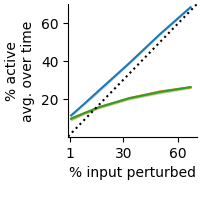

In [5]:
fig, ax = plt.subplots(1, figsize=(2, 2))
sns.lineplot(data=df_vpp, x='d', y='spar3', hue='model',legend=False, ax=ax)
ax.plot([0, 70], [0, 70], ls=':', c='k')
ax.set(ylabel='% active\navg. over time', xticks=[1, 30, 60], yticks=[20, 40, 60], 
       xlim=[0, 70], ylim=[0, 70])
ax.set_xlabel('% input perturbed\n')
fig.savefig('../svg/vary_pert_percent_active.svg')

/home/zg93/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


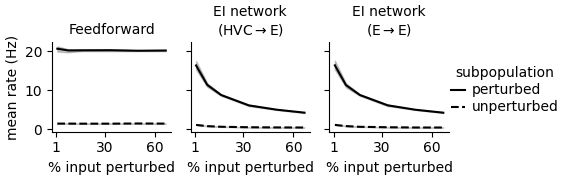

In [6]:
g = sns.FacetGrid(data=df_vpp_z, col='model', hue='subpopulation', 
                  height=2, aspect=0.8, legend_out=True,
                  hue_kws=dict(color=['k','k'],ls=['-','--']))
g.set_titles(col_template='{col_name}')
g.map(sns.lineplot, 'd', 'z')
g.set_axis_labels('% input perturbed', 'mean rate (Hz)')
g.set(xticks=[1, 30, 60])
g.add_legend()
fig.savefig('../svg/supplementary/vary_pert_quality.svg')

In [7]:
df_vid = dict(tid=[], model=[], d=[], mid_pwcorr=[], large_pwcorr=[], 
              spar1=[], spar2=[], spar3=[])

for i in range(1, 6):
    with open('../results/vary_input_dim_%d.pkl' % i, 'rb') as f:
        (FF_pwcorrs, EI_pwcorrs, EIrec_pwcorrs, 
         FF_sparsity, EI_sparsity, EIrec_sparsity) = pickle.load(f)
        df_vid['tid'].extend([i] * len(Ks_input) * len(MODELS))
        aux = [MODELS[0]]*len(Ks_input)+[MODELS[1]]*len(Ks_input)+[MODELS[2]]*len(Ks_input)
        df_vid['model'].extend(aux)
        df_vid['d'].extend(list(NE / Ks_input) * len(MODELS))
        f = lambda x: 100*(np.sum(x>0.8)-NE)/(NE**2-NE)
        df_vid['large_pwcorr'].extend(list(map(f, FF_pwcorrs)))
        df_vid['large_pwcorr'].extend(list(map(f, EI_pwcorrs)))
        df_vid['large_pwcorr'].extend(list(map(f, EIrec_pwcorrs)))
        f = lambda x: np.median(x[np.tril_indices(NE, k=-1)])
        df_vid['mid_pwcorr'].extend(list(map(f, FF_pwcorrs)))
        df_vid['mid_pwcorr'].extend(list(map(f, EI_pwcorrs)))
        df_vid['mid_pwcorr'].extend(list(map(f, EIrec_pwcorrs)))
        
        for th in EI_sparsity.keys():
            df_vid['spar%d'%th].extend(np.vstack(FF_sparsity[th]).mean(axis=1) * 100)
            df_vid['spar%d'%th].extend(np.vstack(EI_sparsity[th]).mean(axis=1) * 100)
            df_vid['spar%d'%th].extend(np.vstack(EIrec_sparsity[th]).mean(axis=1) * 100)

In [8]:
df_vid = pd.DataFrame(df_vid)
df_vid['d_rel'] = df_vid['d'] / NE * 100
df_vid['k'] = 1 / df_vid['d'] * NE

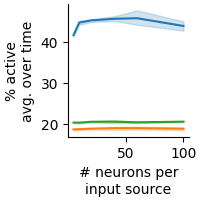

In [9]:
fig, ax = plt.subplots(1, figsize=(2, 2), sharex='all')
sns.lineplot(data=df_vid, x='k', y='spar3', hue='model',legend=False,  ax=ax)
ax.set(ylabel='% active\navg. over time', xlabel='# neurons per\ninput source')
# ax.legend(loc=(0.1, 0.2))
fig.savefig('../svg/vary_input_dim_percent_active.svg')

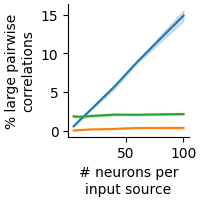

In [10]:
fig, ax = plt.subplots(1, figsize=(2, 2), sharex='all')
sns.lineplot(data=df_vid, x='k', y='large_pwcorr', hue='model',legend=False,  ax=ax)
ax.set(ylabel='% large pairwise\ncorrelations', xlabel='# neurons per\ninput source')
# ax.legend(loc=(0.1, 0.5))
fig.savefig('../svg/vary_input_dim_percent_large_pwcorr.svg')

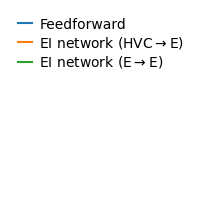

In [11]:
fig, ax = plt.subplots(1, figsize=(2, 2))
ax.set_axis_off()
for i in MODELS:
    ax.plot(0, 0, label=i.replace('\n', ' '))
ax.legend()
fig.savefig('../svg/dummy_label.svg')

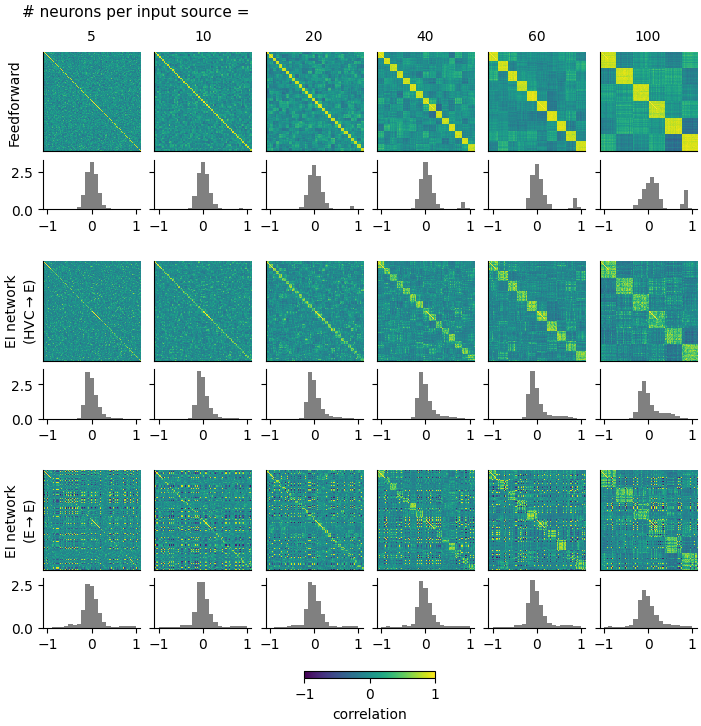

In [12]:
from sklearn.cluster import HDBSCAN
with open('../results/vary_input_dim_%d.pkl' % 1, 'rb') as f:
# with open('../results/vary_percent_pert_%d.pkl' % 1, 'rb') as f:
    EIpwcorrs, FFpwcorrs = pickle.load(f)[:2]
i_sel = list(range(len(EIpwcorrs)))
fig, ax = plt.subplots(6, len(i_sel), figsize=(7, 7), sharex='row', sharey='row', 
                       height_ratios=[1, 0.5, 1, 0.5, 1, 0.5])
ax[0,0].set_ylabel(MODELS[0]+'\n', fontsize=10)
ax[2,0].set_ylabel(MODELS[1], fontsize=10)
ax[4,0].set_ylabel(MODELS[2], fontsize=10)
for k, pwcorrs in enumerate((FF_pwcorrs, EI_pwcorrs, EIrec_pwcorrs)):
    for i, j in enumerate(i_sel):
        # hdb = HDBSCAN(metric='precomputed', min_cluster_size=5)
        # hdb.fit(1-pwcorrs[j])
        # idx = np.argsort(hdb.labels_)[::-1] # [::-1] puts -1 in the end
        # im = ax[k,i].imshow(pwcorrs[j][idx,:][:,idx], vmin=-1, vmax=1, interpolation='none')
        im = ax[k*2,i].imshow(pwcorrs[j], vmin=-1, vmax=1, interpolation='none')
        
        ax[0,i].set_title('%d' % Ks_input[j], fontsize=10, va='bottom')
        ax[k*2,i].set(xticks=[], yticks=[])

        kwargs = dict(range=(-1, 1), bins=21, density=True, color='grey')
        ax[k*2+1,i].hist(pwcorrs[j][np.tril_indices(NE, k=-1)], **kwargs)
        ax[k*2+1,i].set(xlabel='$\\ $')
        
fig.text(0.03, 1.03, '# neurons per input source = ', ha='left', va='top', fontsize=11)
cax = fig.colorbar(im, ax=ax, shrink=0.2, pad=0.0, ticks=[-1, 0, 1], 
                   orientation='horizontal')
cax.set_label('correlation', fontsize=10)
fig.savefig('../svg/supplementary/vary_input_dim_corrmat.svg', bbox_inches='tight')